In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "functions"))
import slicing_functions as sf
import warnings
warnings.filterwarnings('ignore')

if not os.path.exists('data/FigS20_simulation'):
    os.makedirs('data/FigS20_simulation')

seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9


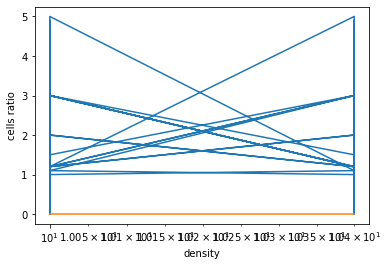

In [2]:
#requires 128GB memory and takes 20+ hours 
#some calculation using 100000 neuron / mm3 from https://doi.org/10.3389/fnana.2018.00083
#max_packing_density = ((100000*(4/3*np.pi*10**3))/1000**3) ~42% with 10µm radius cells 
#our random cell placing method goes up to ~10% and plateaus at ~50000 cell / mm3 TOCHECK
#we are using range of 10 - 50000 cell /mm3 

# set up output 
col_names = ['seed','block_xy','block_z','density','num_points','radius', 'packing_density', 'thickness',
             'keep_every','cells_real','cells_estimated','cells_ratio']
df_results = pd.DataFrame (columns = col_names)

# set up experiment 
radius = 10 # radius of a cell
block_xy = 500 # tissue block xy size in um 
block_z = 4000 # tissue block z size in um
starting_density = 10 #cell per mm^3

# set up density multiplication iteration values
base_value = 1.04
range_low = 0 # multiplier for base value
range_high = 210 
expID = 'final'

# slicing parameters
thickness_low = 25
thickness_high = 100
thickness_delta = thickness_low
keep_every_low = 1
keep_every_high = 10
seed = 0 # random seed

for seed in range (1,101): 
    print ('seed: '+str(int(seed)))
    for i in (base_value**x for x in range(range_low,range_high)):   
        density = starting_density*i  #iterative
        #print ('density: '+str(int(density))+' of max density: '+str(int(starting_density*base_value**(range_high-1))))
        num_points = int(block_xy**2*block_z*density*1e-9) # target number of cells in the volume
        if num_points < 1:
            sys.exit('Zero cells in volume, try higher density')

        # generate tissue block
        df_points = sf.slicing_model_generate (seed, block_xy, block_z, num_points, radius)
        # count cells with different slicing parameters
        for thickness in range (thickness_low, thickness_high+1, thickness_delta):
            for keep_every in range (keep_every_low, keep_every_high+1):

                cells_real, cells_estimated, cells_ratio = sf.slicing_model_count (df_points, radius, block_z, thickness, keep_every)

                packing_density = (cells_real*(4/3*np.pi*radius**3))/(block_xy**2*block_z)
                new_row = {'seed':seed, 'block_xy':block_xy, 'block_z':block_z, 'density':density, 
                       'num_points':num_points, 'radius':radius, 'packing_density':packing_density, 
                       'thickness':thickness, 'keep_every':keep_every, 'cells_real':cells_real, 
                       'cells_estimated':cells_estimated, 'cells_ratio':cells_ratio}
                df_results = df_results.append(new_row, ignore_index = True)


plt.plot(df_results.density, df_results.cells_ratio)
plt.xlabel('density')
plt.xscale('log')
plt.ylabel('cells ratio')
plt.plot(df_results.density, df_results.packing_density)
plt.savefig('data/FigS20_simulation/plot_'+expID+'.png')

df_results.to_hdf('data/FigS20_simulation/results_'+expID+'.h5', key='df', mode='w')
